In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import warnings; warnings.simplefilter('ignore')

import os
import time
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lightfm import LightFM
from lightfm.evaluation import precision_at_k, auc_score

import parallel
import evalutils

N_JOBS = 6
ORI_ID_USER = 'userId'
ORI_ID_ITEM = 'movieId'

SEQ_ID_USER = 'user_id'
SEQ_ID_ITEM = 'item_id'

SOURCE = os.path.expanduser("~/RecSys_Classification")

#Read Data
train = pd.read_hdf(
    os.path.join(SOURCE, 'data/train.hdf'))

test = pd.read_hdf(
    os.path.join(SOURCE, 'data/test.hdf'))

item_catalogue = pd.read_hdf(
    os.path.join(SOURCE, 'data/item_catalogue.hdf'))

i_features = pd.read_hdf(
    os.path.join(SOURCE, 'data/i_features.hdf'))
i_features.sort_values(SEQ_ID_ITEM, inplace=True)

user_id_translator = pd.concat(
    [train, test], axis=0
).drop_duplicates([
    SEQ_ID_USER])[[ORI_ID_USER, SEQ_ID_USER]]
user_id_translator.sort_values(SEQ_ID_USER, inplace=True)

item_id_translator = pd.concat(
    [train, test], axis=0
).drop_duplicates([
    SEQ_ID_ITEM])[[ORI_ID_ITEM, SEQ_ID_ITEM]]
item_id_translator.sort_values(SEQ_ID_ITEM, inplace=True)

# Summary

In [2]:
# genre_features = []
# language_features = []
# for c in i_features.columns:
#     if 'genre' in c:
#         genre_features.append(c)
#     if 'language' in c:
#         language_features.append(c)

# i_features = i_features[genre_features]

In [3]:
userids = set(
    train[SEQ_ID_USER]
).union(
    test[SEQ_ID_USER])

itemids = set(
    train[SEQ_ID_ITEM]
).union(
    test[SEQ_ID_ITEM])

num_users = len(userids)
num_items = len(itemids)

print("num users: %s num items: %s (Transactions)" % (
    num_users, 
    num_items))

num users: 123981 num items: 2479 (Transactions)


## RecSys Train/Test Matrix and User/Item Feature Matrix

In [4]:
train_coo = scipy.sparse.coo_matrix(
        (
            np.ones(train.shape[0]),
            (train[SEQ_ID_USER], train[SEQ_ID_ITEM])
        ),
        shape=(num_users, num_items))
train_coo

<123981x2479 sparse matrix of type '<class 'numpy.float64'>'
	with 1377335 stored elements in COOrdinate format>

In [5]:
test_coo = scipy.sparse.coo_matrix(
        (
            np.ones(test.shape[0]),
            (test[SEQ_ID_USER], test[SEQ_ID_ITEM])
        ),
        shape=(num_users, num_items))
test_coo

<123981x2479 sparse matrix of type '<class 'numpy.float64'>'
	with 136919 stored elements in COOrdinate format>

# Train The RecSys Model

In [6]:
#EPOCHS ITERATIONS
EPOCHS_INCR = 2
EPOCHS = 200
iterations = range(
    EPOCHS_INCR, 
    EPOCHS + EPOCHS_INCR, 
    EPOCHS_INCR)

#Log Variables (Train/Test)
train_auc = []
test_auc = []

#Train Model
model = LightFM(
    learning_rate=0.001,
    item_alpha=.1,
    no_components=30,
    loss='warp')

for epoch in iterations:
    print("[epoch: %s]" % epoch)
    start_time = time.time()

    model.fit_partial(
        train_coo, 
        epochs=EPOCHS_INCR,
        item_features=scipy.sparse.csr_matrix(i_features.values),
        num_threads=N_JOBS)
    
    train_auc_local = auc_score(
        model,
        train_coo,
        item_features=scipy.sparse.csr_matrix(i_features.values),
        num_threads=N_JOBS).mean()
    train_auc.append(train_auc_local)
    
    test_auc_local = auc_score(
        model,
        test_coo,
        item_features=scipy.sparse.csr_matrix(i_features.values),
        num_threads=N_JOBS).mean()
    test_auc.append(test_auc_local)
    
    print('\tTrain AUC: %s.5' % train_auc_local)
    print('\tTest AUC: %s.5' % test_auc_local)
    
    print("Elapsed Time: %smin" % round(
        (time.time() - start_time)/60, 2))

[epoch: 2]
	Train AUC: 0.5248435.5
	Test AUC: 0.4944502.5
Elapsed Time: 0.56min
[epoch: 4]
	Train AUC: 0.5225752.5
	Test AUC: 0.49444008.5
Elapsed Time: 0.55min
[epoch: 6]
	Train AUC: 0.5217162.5
	Test AUC: 0.49443302.5
Elapsed Time: 0.55min
[epoch: 8]
	Train AUC: 0.52130556.5
	Test AUC: 0.494431.5
Elapsed Time: 0.58min
[epoch: 10]
	Train AUC: 0.52105474.5
	Test AUC: 0.49444374.5
Elapsed Time: 0.58min
[epoch: 12]
	Train AUC: 0.5208256.5
	Test AUC: 0.4944427.5
Elapsed Time: 0.58min
[epoch: 14]
	Train AUC: 0.5207323.5
	Test AUC: 0.4944416.5
Elapsed Time: 0.57min
[epoch: 16]
	Train AUC: 0.52058977.5
	Test AUC: 0.49444026.5
Elapsed Time: 0.55min
[epoch: 18]
	Train AUC: 0.5204378.5
	Test AUC: 0.49443933.5
Elapsed Time: 0.59min
[epoch: 20]
	Train AUC: 0.5203329.5
	Test AUC: 0.4944386.5
Elapsed Time: 0.54min
[epoch: 22]
	Train AUC: 0.5202544.5
	Test AUC: 0.49443784.5
Elapsed Time: 0.56min
[epoch: 24]
	Train AUC: 0.5202023.5
	Test AUC: 0.49443716.5
Elapsed Time: 0.54min
[epoch: 26]
	Train AUC:

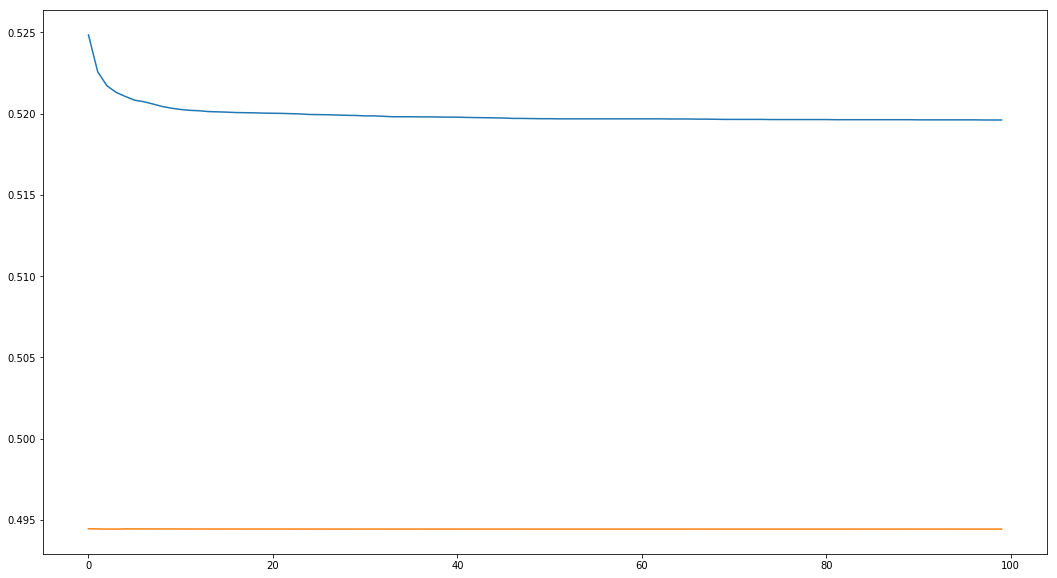

In [7]:
fig, ax = plt.subplots(1, 1)

pd.Series(train_auc).plot(figsize=(18, 10), ax=ax)
pd.Series(test_auc).plot(figsize=(18, 10), ax=ax)

# Train Precision / Test Precision

# GB

In [8]:
#Get embeddings from RecSys Model
# item_emb = pd.DataFrame(model.item_embeddings)
# item_emb = item_emb.add_prefix("i_latent_")

user_emb = pd.DataFrame(model.user_embeddings)
user_emb = user_emb.add_prefix("u_latent_")

#Join all items and get unique SEQ_ID, ORI_ID pairs
ui_trans = pd.concat([train, test], axis=0)

user_ids = ui_trans[[SEQ_ID_USER, ORI_ID_USER]].drop_duplicates()
# item_ids = ui_trans[[SEQ_ID_ITEM, ORI_ID_ITEM]].drop_duplicates()

#user/item embeddings original IDs
user_emb[ORI_ID_USER] = user_ids[ORI_ID_USER].values
# item_emb[ORI_ID_ITEM] = item_ids[ORI_ID_ITEM].values

# #Set IDs as index
user_emb.set_index(ORI_ID_USER, inplace=True)
# item_emb.set_index(ORI_ID_ITEM, inplace=True)

In [9]:
"""
For the classification task we will merely use 
the user embedding obtained from the RecSys model
in order to predict the movie genre a user will
watch.
"""

#Get candidates for the task
candidates_classification = test.sort_values(
    'timestamp',
    ascending=True
).drop_duplicates(
    SEQ_ID_USER,
    keep='first')

In [10]:
#Split Train/Test
train_portion = .8
n = candidates_classification.shape[0]
train_size = int(n * train_portion)

candidates_classification.reset_index(inplace=True)
X_train_ids = candidates_classification.sample(train_size)
X_test_ids = candidates_classification[~candidates_classification.index.isin(X_train_ids.index)]

X_train_ids = X_train_ids[[SEQ_ID_ITEM, ORI_ID_USER]]
X_test_ids = X_test_ids[[SEQ_ID_ITEM, ORI_ID_USER]]

In [11]:
#Order embeddings according to train/test respectively
X_train = user_emb.loc[X_train_ids[ORI_ID_USER]]
X_test = user_emb.loc[X_test_ids[ORI_ID_USER]]

#Get genres of train/test respectively
item_catalogue.index = item_catalogue[SEQ_ID_ITEM]

y_train = item_catalogue.loc[X_train_ids[SEQ_ID_ITEM]]['genres']
y_test = item_catalogue.loc[X_test_ids[SEQ_ID_ITEM]]['genres']

In [12]:
all_genres = {}
for genres in y_train:
    for g in genres:
        if g in all_genres:
            all_genres[g] += 1
        else:
            all_genres[g] = 1
            
all_genres = pd.Series(all_genres)

genres_to_num = dict([(c, it) for it, c in enumerate(all_genres.keys())])

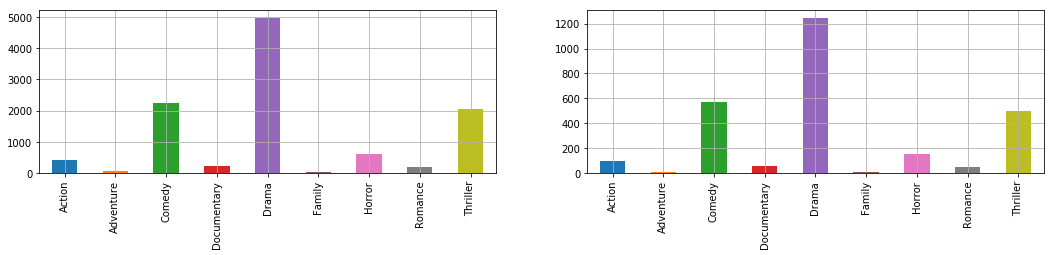

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(18, 3))
(y_train.value_counts()).sort_index().plot(
    kind='bar', 
    grid=True, 
    ax=ax[0]);

(y_test.value_counts()).sort_index().plot(
    kind='bar', 
    grid=True, 
    ax=ax[1]);

# XGB Simple

In [14]:
import xgboost as xgb

cls = xgb.XGBClassifier(n_estimators=200, n_jobs=N_JOBS)
cls.fit(pd.DataFrame(X_train.values), y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=6, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


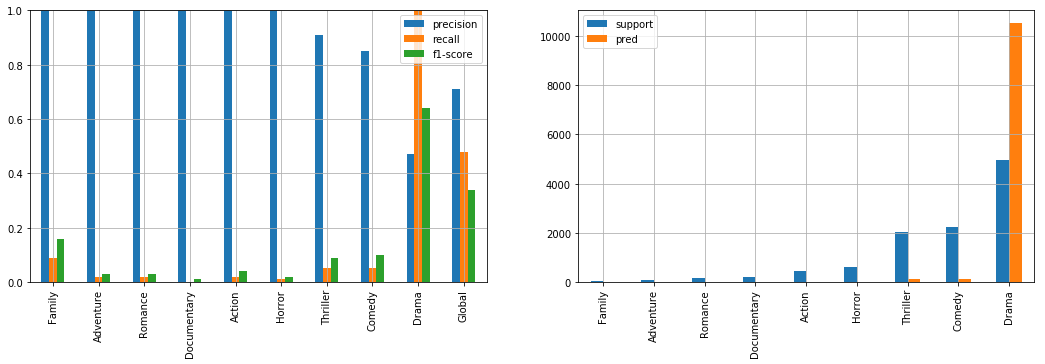

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
train_report = evalutils.class_report(
    y_true=y_train,
    y_pred=cls.predict(pd.DataFrame(X_train.values)))

train_report.sort_values('support')[['precision', 'recall' ,'f1-score']].plot(
    kind='bar',
    grid=True,
    ylim=(0, 1),
    ax=ax[0])

train_report.drop('Global')[['support', 'pred']].sort_values('support').plot(
    kind='bar',
    grid=True,
    ax=ax[1])

fig.set_size_inches(18, 5)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


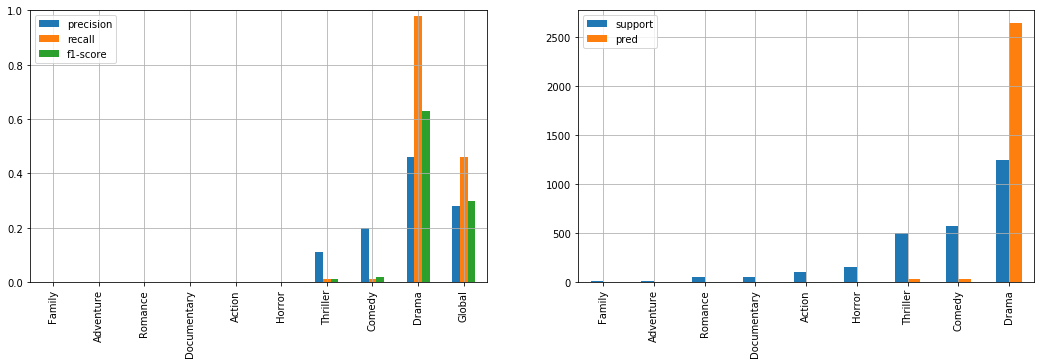

In [16]:
fig, ax = plt.subplots(1, 2)
test_report = evalutils.class_report(
    y_true=y_test,
    y_pred=cls.predict(pd.DataFrame(X_test.values)))

test_report.sort_values('support')[['precision', 'recall' ,'f1-score']].plot(
    kind='bar',
    grid=True,
    ylim=(0, 1),
    ax=ax[0])

test_report.drop('Global')[['support', 'pred']].sort_values('support').plot(
    kind='bar',
    grid=True,
    ax=ax[1])

fig.set_size_inches(18, 5)

# XGB Binary

In [17]:
genres = pd.concat([y_train, y_test]).unique()
id_genre = dict([(genre, it) for it, genre in enumerate(genres)])

In [18]:
import sys; sys.path.append("/home/ubuntu/XGB-BINARY/")
from XGBBinary import XGBBinary

gridsearch = {
    'learning_rate': [.1, .01],
    'gamma': [.1, 1, .5],
    'n_estimators': [100],
    'n_jobs': [6],
    'eval_set': [[(pd.DataFrame(X_test.values), y_test.apply(lambda x: id_genre[x]))]],
    'early_stopping': [10, 50, 100],
}

cls_bin = XGBBinary(
    gridsearch=gridsearch,
    cross_validation=2,
    verbose=False)

cls_bin.fit(
    X_train.values, 
    y_train.apply(lambda x: id_genre[x]))

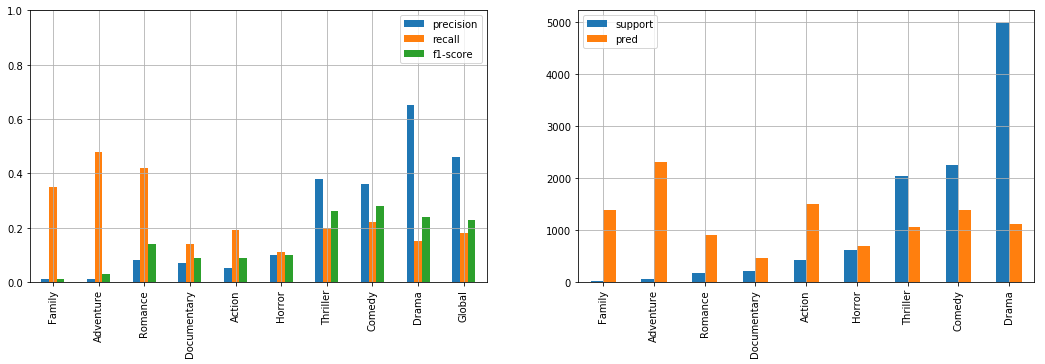

In [19]:
genre_id = dict([(v,k) for k,v in id_genre.items()])

fig, ax = plt.subplots(1, 2)
test_report = evalutils.class_report(
    y_true=y_train,
    y_pred=[genre_id[y] for y in cls_bin.predict(X_train.values)])

test_report.sort_values('support')[['precision', 'recall' ,'f1-score']].plot(
    kind='bar',
    ylim=(0, 1),
    grid=True,
    ax=ax[0])

test_report.drop('Global')[['support', 'pred']].sort_values('support').plot(
    kind='bar',
    grid=True,
    ax=ax[1])

fig.set_size_inches(18, 5)

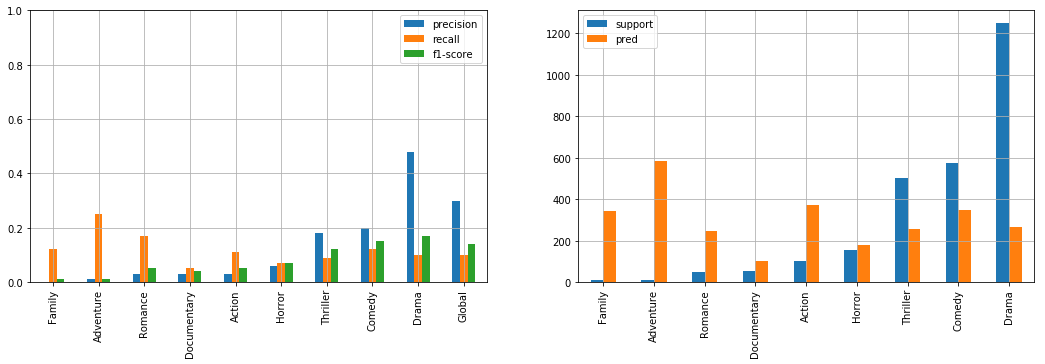

In [20]:
fig, ax = plt.subplots(1, 2)
test_report = evalutils.class_report(
    y_true=y_test,
    y_pred=[genre_id[y] for y in cls_bin.predict(X_test.values)])

test_report.sort_values('support')[['precision', 'recall' ,'f1-score']].plot(
    kind='bar',
    ylim=(0, 1),
    grid=True,
    ax=ax[0])

test_report.drop('Global')[['support', 'pred']].sort_values('support').plot(
    kind='bar',
    grid=True,
    ax=ax[1])

fig.set_size_inches(18, 5)

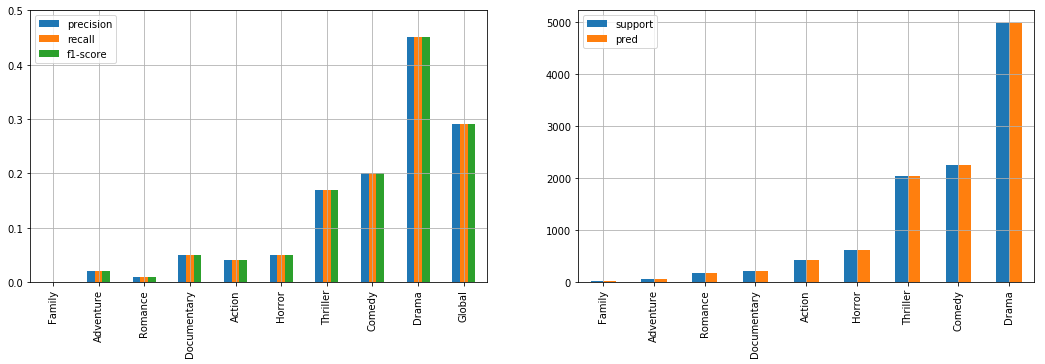

In [21]:
fig, ax = plt.subplots(1, 2)
test_report = evalutils.class_report(
    y_true=y_train,
    y_pred=y_train.sample(y_train.shape[0]))

test_report.sort_values('support')[['precision', 'recall' ,'f1-score']].plot(
    kind='bar',
    grid=True,
    ylim=(0, .5),
    ax=ax[0])

test_report.drop('Global')[['support', 'pred']].sort_values('support').plot(
    kind='bar',
    grid=True,
    ax=ax[1])

fig.set_size_inches(18, 5)